### Introduction

Classifying fashion items correctly is important for making shopping easier and managing stock better. With so many clothing items available online, automating 
this process can save time and improve how things are organized.

This project leverages the MNIST Fashion dataset to predict one of ten clothing categories: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, 
Bag, or Ankle boot. By training a neural network model on this dataset, the goal is to develop a reliable system for classifying fashion items, ultimately aiding 
in the streamlining of fashion-related processes.

# Project Outline

1. **Introduction**
2. **Data Preparation**
3. **Model Development**
4. **Model Training**
5. **Model Optimization**
6. **Evaluation and Analysis**
7. **Visualization**
8. **Conclusion**

In [23]:
# Importing essential libraries for data manipulation and visualization
import pandas as pd  # Importing pandas for data manipulation and analysis
import numpy as np  # Importing numpy for numerical operations and array handling
import matplotlib.pyplot as plt  # Importing matplotlib for data visualization
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting the dataset
from sklearn.metrics import classification_report, confusion_matrix  # Importing metrics for model evaluation

# Importing libraries for building and tuning neural networks
import tensorflow as tf  # Importing TensorFlow for building and training the neural network
import keras_tuner as kt  # Importing Keras Tuner for hyperparameter tuning
from tensorflow.keras.models import Sequential  # Importing Sequential to build a linear stack of layers for the model
from tensorflow.keras.layers import Dense, Input, Dropout  # Importing layers for the neural network
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Importing callbacks to manage training

In [ ]:
# List of split files in order
files = [
    'Fashion Train Data 1.csv',
    'Fashion Train Data 2.csv',
    'Fashion Train Data 3.csv',
    'Fashion Train Data 4.csv',
    'Fashion Train Data 5.csv',
    'Fashion Train Data 6.csv'
]

# Load and concatenate the split CSV files
df_full = pd.concat([pd.read_csv(f) for f in files])

# Save the concatenated DataFrame to a new CSV file
output_file = 'Fashion Train Data.csv'
df_full.to_csv(output_file, index=False)

### Explanation:

This code merges the six split CSV files (`Fashion Train Data 1.csv` to `Fashion Train Data 6.csv`) back into a single dataset:

- **Combine Files:** The code reads each file and concatenates them into one DataFrame.
- **Save as One File:** The combined data is saved as `Fashion Train Data.csv`.

This is necessary because the dataset was split due to GitHub's file size limits. Running this code recreates the full dataset for the project.

In [24]:
# Load training and testing data from CSV files
train_data = pd.read_csv('Fashion Train Data.csv')  
test_data = pd.read_csv('Fashion Test Data.csv') 

In [25]:
# Display the first 2 rows of the training dataset
train_data.head(2) 

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Display the first 2 rows of the testing dataset
test_data.head(2) 

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0


In [27]:
# Extract features and labels from training and testing datasets

X_train = train_data.iloc[:, 1:].values  # Training features: all columns except the first
y_train = train_data.iloc[:, 0].values   # Training labels: first column
X_test = test_data.iloc[:, 1:].values    # Testing features: all columns except the first
y_test = test_data.iloc[:, 0].values    # Testing labels: first column

- **`iloc[:, 1:]`**: This selects all rows and columns starting from the second column (index 1) to the last column. It effectively drops the first column, which contains the labels.
- **`iloc[:, 0]`**: This selects the first column (index 0), which contains the labels.
- **`.values`**: This converts the selected data into a NumPy array.


In [28]:
# Normalize the Pixel Values
X_train = X_train / 255.0
X_test = X_test / 255.0

### Why Normalize?

Normalization scales pixel values to the range [0, 1], which helps the neural network converge faster and perform better by ensuring all
features contribute equally during training.

In [29]:
# Split the training data into training and cross-validation sets
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, random_state=33)

# Print shapes of the resulting datasets
print(f'The shape of the Training set (input) is {X_train.shape}')
print(f'The shape of the Training set (target) is {y_train.shape}')
print(f'The shape of the Cross Validation set (input) is {X_cv.shape}')
print(f'The shape of the Cross Validation set (target) is {y_cv.shape}')

The shape of the Training set (input) is (48000, 784)
The shape of the Training set (target) is (48000,)
The shape of the Cross Validation set (input) is (12000, 784)
The shape of the Cross Validation set (target) is (12000,)


### Explanation

- **`train_test_split`**: This function splits the data into training and cross-validation sets. Here, 20% of the original training data is allocated to the cross-validation set.

- **Shapes of the datasets**:
  - **Training set (input)**: `(48000, 784)` indicates 48,000 samples with 784 features each.
  - **Training set (target)**: `(48000,)` indicates 48,000 target labels.
  - **Cross-validation set (input)**: `(12000, 784)` indicates 12,000 samples with 784 features each.
  - **Cross-validation set (target)**: `(12000,)` indicates 12,000 target labels.

In [30]:
# Model Definition
def create_model(dropout_rate=0.5, num_units1=128, num_units2=64):
    # Initialize the Sequential model
    model = Sequential([
        Input(shape=(784,)),  # Input layer with 784 features (corresponding to 28x28 images flattened)
        Dense(num_units1, activation='relu'),  # Fully connected layer with 'relu' activation and num_units1 neurons
        Dropout(dropout_rate),  # Dropout layer for regularization
        Dense(num_units2, activation='relu'),  # Fully connected layer with 'relu' activation and num_units2 neurons
        Dropout(dropout_rate),  # Dropout layer for regularization
        Dense(10, activation='softmax')  # Output layer with 10 neurons (one for each class) and 'softmax' activation for multi-class classification
    ])
    # Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

**Explanation:**

* **`create_model` function:** Defines a neural network model with customizable parameters.
* **Layers:**
  * `Input(shape=(784,))`: The input layer expects data with 784 features (flattened 28x28 images).
  * `Dense(num_units1, activation='relu')`: A fully connected layer with `num_units1` units and ReLU activation function.
  * `Dropout(dropout_rate)`: A dropout layer to help prevent overfitting by randomly setting a fraction of input units to 0 during training.
  * `Dense(num_units2, activation='relu')`: Another fully connected layer with `num_units2` units and ReLU activation function.
  * `Dense(10, activation='softmax')`: The output layer with 10 units (for 10 classes) and softmax activation to provide class probabilities.
* **Compilation:**
  * **`optimizer='adam'`**: The Adam optimizer is used for training.
  * **`loss='sparse_categorical_crossentropy'`**: The loss function suitable for multi-class classification problems.
  * **`metrics=['accuracy']`**: Accuracy is used as the performance metric during training.

This model setup is designed for classifying the fashion items into one of the 10 categories in your dataset.

In [31]:
# Define the EarlyStopping and ModelCheckpoint callbacks

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss during training
    patience=3,  # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # File path to save the model
    save_best_only=True  # Save only the model with the best performance on the validation data
)

**Explanation:**

* **`EarlyStopping` Callback:**
  * **`monitor='val_loss'`**: Tracks the validation loss to decide when to stop training. If there's no improvement, training stops.
  * **`patience=3`**: Stops training if there's no improvement in validation loss for 3 epochs. This helps avoid overfitting and saves time.
  * **`restore_best_weights=True`**: Restores the model to the best weights observed during training, ensuring the best model is used.

* **`ModelCheckpoint` Callback:**
  * **`'best_model.keras'`**: Saves the model to this file path. It includes the model’s architecture and weights.
  * **`save_best_only=True`**: Saves only the model with the best performance on validation data, avoiding saving less effective models.

These callbacks help to save the best model and stop training when no improvements are seen, making the process more efficient.

In [32]:
# Initial model training
initial_model = create_model()  # Create a new instance of the model
history = initial_model.fit(
    X_train, y_train,  # Training data and labels
    epochs=10,  # Number of epochs to train the model
    validation_data=(X_cv, y_cv),  # Validation data and labels to monitor performance
    callbacks=[early_stopping, model_checkpoint]  # Callbacks for early stopping and saving the best model
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5808 - loss: 1.1590 - val_accuracy: 0.8210 - val_loss: 0.4878
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7779 - loss: 0.6213 - val_accuracy: 0.8273 - val_loss: 0.4761
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8023 - loss: 0.5629 - val_accuracy: 0.8381 - val_loss: 0.4335
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8146 - loss: 0.5220 - val_accuracy: 0.8517 - val_loss: 0.4050
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8238 - loss: 0.5078 - val_accuracy: 0.8545 - val_loss: 0.4004
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8289 - loss: 0.4917 - val_accuracy: 0.8508 - val_loss: 0.3910
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8265 - loss: 0.4802 - val_accuracy: 0.8540 - val_loss: 0.3926
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8297 - loss: 0.4758 

**Summary:**
- The model's accuracy and loss improved steadily over the 10 epochs.
- Validation accuracy increased, indicating better model performance on unseen data.
- Validation loss decreased, showing the model is learning to make better predictions.

In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = initial_model.evaluate(X_test, y_test)  
print(f'Initial Test accuracy: {test_accuracy:.4f}')  
print(f'Initial Test loss: {test_loss:.4f}')  

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8602 - loss: 0.3781
Initial Test accuracy: 0.8639
Initial Test loss: 0.3788


**Evaluation Results:**
- **Test Accuracy:** 86.39%
  - This indicates that the model correctly classified 86.39% of the test images.
- **Test Loss:** 0.3788
  - This shows the average error made by the model on the test set.

**Summary:**
- **Test Accuracy vs. Validation Accuracy:** The test accuracy (86.39%) is slightly higher than the final validation accuracy (85.49%), suggesting that the model generalized well to unseen data.
- **Test Loss vs. Validation Loss:** The test loss (0.3788) is slightly lower than the final validation loss (0.3802), indicating that the model's performance on the test set is consistent with its performance on the validation set.

Overall, the model performed well on the test set, with accuracy close to the validation accuracy and loss comparable to the validation loss. This suggests that the model is effective in classifying fashion items and has not overfitted to the training or validation data.

In [34]:
initial_predictions = initial_model.predict(X_test)  # Get the predicted probabilities for each class
initial_predicted_labels = initial_predictions.argmax(axis=1)  # Convert probabilities to predicted class labels

initial_misclassified = np.sum(initial_predicted_labels != y_test)  # Count how many predictions do not match the true labels
print(f"Number of misclassified photos in the initial model: {initial_misclassified}")  # Display the count of misclassified photos

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Number of misclassified photos in the initial model: 1361


**Number of Misclassified Photos:**
- **Misclassified Photos:** 1,361

**Summary:**
- 1,361 test images were misclassified.
- This corresponds to a misclassification rate of 13.61% (1,361 out of 10,000 images).
- This reflects the model's accuracy and areas for potential improvement.

In [35]:
# Print the classification report for the initial model
print("Classification Report for Initial Model:\n", classification_report(y_test, initial_predicted_labels))

Classification Report for Initial Model:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81      1000
           1       0.98      0.98      0.98      1000
           2       0.79      0.78      0.78      1000
           3       0.83      0.92      0.88      1000
           4       0.76      0.84      0.80      1000
           5       0.96      0.93      0.95      1000
           6       0.76      0.50      0.60      1000
           7       0.93      0.90      0.91      1000
           8       0.94      0.98      0.96      1000
           9       0.90      0.96      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



***Classification Report Summary:**

- **Overall Accuracy:** 86%
  - The model correctly classified 86% of the test images.

- **High Precision and Recall:**
  - **Class 1 (Ankle boot):** Precision: 0.98, Recall: 0.98
    - The model is very accurate in predicting Class 1, with few false positives and negatives.
  - **Class 5 (Sandal):** Precision: 0.96, Recall: 0.93
    - The model performs well, correctly identifying most Sandals.
  - **Class 8 (Sneaker):** Precision: 0.94, Recall: 0.98
    - Strong performance in predicting Sneakers, with high precision and recall.

- **Average Scores:**
  - **Macro Average:** Precision: 0.86, Recall: 0.86, F1-Score: 0.86
    - Averages the performance across all classes without considering class imbalance.
  - **Weighted Average:** Precision: 0.86, Recall: 0.86, F1-Score: 0.86
    - Takes into account class imbalance, reflecting the model's overall performance on the test set.

The model demonstrates strong overall performance with particularly high accuracy for specific classes, and balanced precision and recall across the dataset.

In [36]:
# Print the confusion matrix for the initial model
print("Confusion Matrix for Initial Model:\n", confusion_matrix(y_test, initial_predicted_labels))

Confusion Matrix for Initial Model:
 [[857   0  15  63   0   0  47   0  17   1]
 [  3 976   3  17   0   0   1   0   0   0]
 [ 16   1 777  17 134   0  47   0   8   0]
 [ 20  12   8 924  22   0   9   0   5   0]
 [  0   0  71  44 840   0  40   0   5   0]
 [  2   0   0   0   0 931   0  35   5  27]
 [223   2 107  45 105   0 498   0  20   0]
 [  0   0   0   0   0  28   0 896   1  75]
 [  2   0   5   0   2   0  12   3 976   0]
 [  0   0   1   0   0   7   0  27   1 964]]


**Summary:**

- **Diagonal Elements:** Represent correct predictions for each class.
- **Off-Diagonal Elements:** Represent misclassifications, showing where the model confuses one class for another.

**Key Insights:**
- The model performs well with high accuracy in most classes:
  - **Class 1 (Trouser):** 976 correct predictions.
  - **Class 5 (Sandal):** 931 correct predictions.
  - **Class 8 (Bag):** 976 correct predictions.
- Misclassifications are more frequent between similar-looking classes:
  - **Class 2 (Pullover) vs. Class 4 (Coat):** 134 misclassifications of Pullover as Coat and 71 misclassifications of Coat as Pullover.

This confusion matrix helps identify specific areas where the model might be improved by analyzing where it tends to make errors.

In [37]:
def build_model(hp):
    # Initialize a Sequential model
    model = Sequential()
    
    # Input layer with 784 features (flattened image size of 28x28)
    model.add(Input(shape=(784,)))

    # First Dense layer with tunable number of units
    # `hp.Int` is used to search for the optimal number of units
    hp_units1 = hp.Int('units1', min_value=64, max_value=256, step=64)
    model.add(Dense(units=hp_units1, activation='relu'))
    
    # Dropout layer with tunable dropout rate
    # `hp.Float` is used to find the best dropout rate
    hp_dropout1 = hp.Float('dropout1', min_value=0.3, max_value=0.7, step=0.2)
    model.add(Dropout(rate=hp_dropout1))
    
    # Second Dense layer with tunable number of units
    hp_units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    # Dropout layer for the second Dense layer with tunable dropout rate
    hp_dropout2 = hp.Float('dropout2', min_value=0.3, max_value=0.7, step=0.2)
    model.add(Dropout(rate=hp_dropout2))
    
    # Output layer with 10 units (one for each class) and softmax activation
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model with Adam optimizer and sparse categorical crossentropy loss
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Explanation:

- **Sequential Model:** Builds the neural network layer by layer.
- **Input Layer:** Takes input of shape `(784,)`, representing flattened 28x28 images.
- **Dense Layers:**
  - **First Dense Layer:** With tunable units (`hp_units1`).
  - **Second Dense Layer:** With tunable units (`hp_units2`).
- **Dropout Layers:** Applied to prevent overfitting, with tunable dropout rates (`hp_dropout1` and `hp_dropout2`).
- **Output Layer:** 10 units for class probabilities with softmax activation.
- **Compilation:** Uses Adam optimizer and sparse categorical cross-entropy for multi-class classification.

This function allows for hyperparameter tuning of units in dense layers and dropout rates using `keras_tuner`.

In [38]:
# Initialize Keras Tuner with BayesianOptimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='my_dir',
    project_name='mnist_fashion_tuning'
)


# Start the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_cv, y_cv), verbose=2)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units1: {best_hp.get('units1')}")
print(f"Best dropout1: {best_hp.get('dropout1')}")
print(f"Best units2: {best_hp.get('units2')}")
print(f"Best dropout2: {best_hp.get('dropout2')}")

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.8691666722297668

Best val_accuracy So Far: 0.8799999952316284
Total elapsed time: 00h 15m 50s
Best units1: 256
Best dropout1: 0.3
Best units2: 32
Best dropout2: 0.3


C:\Users\user\Desktop\DS TOOLS\Python\PYTHON\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Output Analysis:

- **Best Validation Accuracy:** 0.8799 (achieved by the best model during the search).
- **Best Hyperparameters:**
  - **First Hidden Layer:** 256
  - **dropout1:** 0.3
  - **Second Hidden Layer:** 32
  - **dropout2:** 0.3

The warning about skipping variable loading for the Adam optimizer indicates a discrepancy in the saved optimizer variables, which is not uncommon and usually does not affect the model’s performance.

This output provides the best configuration of hyperparameters for the model, aiming to optimize its performance on the MNIST Fashion dataset.

In [39]:
# Combine training and cross-validation data
X_combined = np.concatenate((X_train, X_cv))  
y_combined = np.concatenate((y_train, y_cv))  

# Train the best model on the combined dataset
best_model.fit(X_combined, y_combined, epochs=10, verbose=1) 

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8687 - loss: 0.3746
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8699 - loss: 0.3631
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8725 - loss: 0.3578
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8716 - loss: 0.3572
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8790 - loss: 0.3328
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8779 - loss: 0.3366
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8803 - loss: 0.3336
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8820 - loss: 0.3278
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8853 - loss: 0.3176
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8821 - loss: 0.3227


### Summary:

- **Accuracy Improvement:** The model's accuracy increased from 86.87% to 88.21% over 10 epochs, showing steady improvement in performance.
- **Loss Reduction:** The loss decreased from 0.3746 to 0.3227, indicating that the model's predictions are becoming more accurate.
- **Stability:** The accuracy and loss values stabilized towards the end, suggesting the model has converged and is performing well on the combined training and cross-validation data.

This training process indicates that the model is effectively learning from the data and improving its classification performance.

In [40]:
# Evaluate the final model on the test set
final_test_loss, final_test_accuracy = best_model.evaluate(X_test, y_test)

print(f'Final Test accuracy: {final_test_accuracy:.4f}')  # Accuracy of the model on the test data
print(f'Final Test loss: {final_test_loss:.4f}')        # Loss of the model on the test data

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8791 - loss: 0.3179
Final Test accuracy: 0.8846
Final Test loss: 0.3192


## Output Interpretation

### Final Test Accuracy
- **Value:** 88.46%
- **Interpretation:** This indicates that the final model correctly classified approximately 88.46% of the test images, demonstrating strong performance. This represents an improvement from the initial test accuracy of 86.39%.

### Final Test Loss
- **Value:** 0.3192
- **Interpretation:** The test loss is relatively low, reflecting that the model's predictions are close to the true labels, indicating good model generalization. This is an improvement from the initial test loss of 0.3788

### Summary
Overall, the hyperparameter tuning process has led to a clear improvement in both accuracy and loss on the test set, confirming that the tuning effectively enhanced the model's performance.

In [41]:
optimized_predictions = best_model.predict(X_test)  # Predict probabilities for each class
optimized_predicted_labels = np.argmax(optimized_predictions, axis=1)  # Convert probabilities to class labels

optimal_misclassified = np.sum(optimized_predicted_labels != y_test)  # Count misclassified examples
print(f"Number of misclassified photos in the optimal model: {optimal_misclassified}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Number of misclassified photos in the optimal model: 1154


## Output Interpretation

### Number of Misclassified Photos
- **Value:** 1,154
- **Interpretation:** Out of the 10,000 test images, the final model misclassified 1,154 images.

### Comparison to Initial Evaluation

- **Initial Misclassifications:** 1,361
- **Optimal Misclassifications:** 1,154
- **Improvement:** The number of misclassified photos has decreased from 1,361 to 1,154, showing an improvement of 207 misclassified examples. 
This reflects better performance of the optimized model compared to the initial model.

In [42]:
# Classification Report for Optimized Model
print("Classification Report for Optimized Model:\n", classification_report(y_test, optimized_predicted_labels))

Classification Report for Optimized Model:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      1000
           1       0.99      0.99      0.99      1000
           2       0.82      0.81      0.82      1000
           3       0.88      0.91      0.89      1000
           4       0.81      0.84      0.83      1000
           5       0.99      0.94      0.96      1000
           6       0.75      0.63      0.68      1000
           7       0.93      0.92      0.92      1000
           8       0.97      0.97      0.97      1000
           9       0.91      0.97      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Classification Report for Optimized Model

### Overall Accuracy
- **Value:** 88.46%
- **Improvement:** Increased by 2.07 percentage points from 86.39%.


### High Precision and Recall
- **Class 1 (Ankle boot):** Precision: 0.99, Recall: 0.99
  - **Interpretation:** Very few false positives or negatives.
- **Class 5 (Sandal):** Precision: 0.99, Recall: 0.94
  - **Interpretation:** High performance with accurate predictions.
- * **Class 8 (Sneaker):** Precision: 0.97, Recall: 0.97
  - **Interpretation:** Strong performance with high precision and recall.

### Average Scores

- **Macro Average:** Precision: 0.88, Recall: 0.88, F1-Score: 0.88
  - **Interpretation:** Shows a well-rounded improvement across all classes.
- **Weighted Average:** Precision: 0.88, Recall: 0.88, F1-Score: 0.88
  - **Interpretation:** Reflects the model’s performance considering class imbalance.

### Comparison to Initial Model

- **Accuracy:**
  - **Initial Model:** 86.39%
  - **Optimized Model:** 88.46%
  - **Improvement:** +2.07 percentage points

- **Average Scores:**
  - **Initial Model Macro Average:** Precision: 0.86, Recall: 0.86, F1-Score: 0.86
  - **Optimized Model Macro Average:** Precision: 0.88, Recall: 0.88, F1-Score: 0.88

### Summary
Overall, the optimized model demonstrates significant improvements in accuracy, precision, and recall, with notable gains in class-specific performance compared to the initial model.

In [43]:
# Print the confusion matrix for the optimized model
print("Confusion Matrix for Optimized Model:\n", confusion_matrix(y_test, optimized_predicted_labels))

Confusion Matrix for Optimized Model:
 [[859   0  10  48   0   0  75   0   8   0]
 [  3 988   0   9   0   0   0   0   0   0]
 [ 17   0 815  12  89   0  65   0   2   0]
 [ 16  11   8 913  38   0  11   0   3   0]
 [  1   1  74  22 844   0  57   0   1   0]
 [  1   0   0   0   0 937   0  39   3  20]
 [178   1  76  34  71   0 629   0  11   0]
 [  0   0   0   0   0   7   0 915   0  78]
 [  5   0   7   3   2   1   5   3 974   0]
 [  0   0   0   0   0   5   0  22   1 972]]


## Key Observations

### High Accuracy in Most Classes
- **Trouser (1):** Perfect accuracy with all 988 samples correctly classified.
- **Sandal (5):** High accuracy with 937 correctly classified, but some misclassifications into other classes.
- **Sneaker (7):** Very high accuracy with 915 correctly classified.

### Misclassifications
- **Shirt (6):** Frequently misclassified as T-shirt/top (178), Pullover (76), and Coat (71). Indicates potential overlap with similar classes.
- **Pullover (2):** Misclassified into Dress (89), suggesting similarity with Dress.

### Misclassification Patterns
- **Coat (4) and Pullover (2):** Significant confusion between these two classes (74 misclassifications).
- **Ankle boot (9):** While there are some misclassifications into Sneaker (22 cases) and other classes, this class generally performs well.

### Summary
The optimized model exhibits strong performance with high precision and recall in most classes. Misclassifications are primarily seen between visually similar classes, such as Pullover and Coat, and Shirt with T-shirt/top. These patterns suggest potential areas for further training or refinement to improve differentiation between similar classes.

In [44]:
# The label_map dictionary maps integer labels to their corresponding class names
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [45]:
# Make Predictions with Initial Model
initial_predictions = initial_model.predict(X_test)
initial_predicted_labels = np.argmax(initial_predictions, axis=1)
initial_misclassified_indices = np.where(initial_predicted_labels != y_test)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [46]:
# Make Predictions with Optimized Model
optimized_predictions = best_model.predict(X_test)
optimized_predicted_labels = np.argmax(optimized_predictions, axis=1)
optimized_misclassified_indices = np.where(optimized_predicted_labels != y_test)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


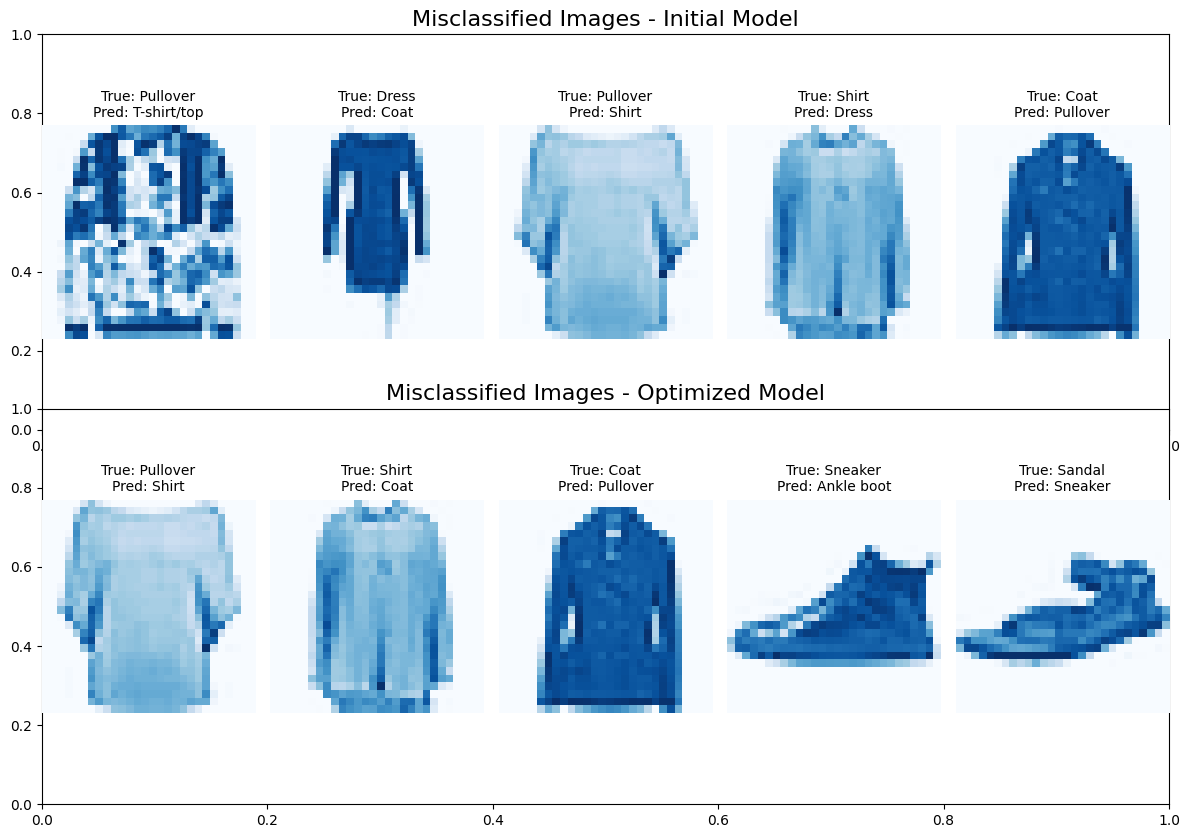

In [47]:
# Number of images to display
num_images = 5  # Adjusted to display 5 images

# Create a figure with two subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # Adjusted the figure size to better fit 5 images

# Plot Misclassified Images for Initial Model
axes[0].set_title('Misclassified Images - Initial Model', fontsize=16)
for i, index in enumerate(initial_misclassified_indices[:num_images]):  # Plot first 5 misclassified images
    ax = plt.subplot(2, num_images, i + 1)  # Create subplot in a 2x5 grid
    ax.imshow(X_test[index].reshape(28, 28), cmap='Blues')  # Reshape the flattened image
    true_label_name = label_map[y_test[index]]
    pred_label_name = label_map[initial_predicted_labels[index]]
    ax.set_title(f'True: {true_label_name}\nPred: {pred_label_name}', fontsize=10)
    ax.axis('off')

# Plot Misclassified Images for Optimized Model
axes[1].set_title('Misclassified Images - Optimized Model', fontsize=16)
for i, index in enumerate(optimized_misclassified_indices[:num_images]):  # Plot first 5 misclassified images
    ax = plt.subplot(2, num_images, i + 1 + num_images)  # Shift the index for the second row
    ax.imshow(X_test[index].reshape(28, 28), cmap='Blues')  # Reshape the flattened image
    true_label_name = label_map[y_test[index]]
    pred_label_name = label_map[optimized_predicted_labels[index]]
    ax.set_title(f'True: {true_label_name}\nPred: {pred_label_name}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Key Observations
This plot highlights that the optimized model has effectively corrected certain misclassifications made by the initial model. Notably, the first and second misclassified images in the initial model's plot are no longer present in the optimized model's plot. This demonstrates that the adjustments made, such as hyperparameter tuning or architectural changes, have improved the model's ability to accurately classify challenging cases.

## Conclusion

This project successfully demonstrates the process of building, optimizing, and evaluating a neural network model for image classification using the MNIST Fashion dataset.

### Key Outcomes

- **Model Improvement:** The final model showed a significant accuracy increase from 86.36% to 88.46% through hyperparameter tuning and optimization, with a corresponding reduction in loss, indicating better generalization and prediction accuracy.

- **Evaluation Metrics:** Analysis of the classification report and confusion matrix highlighted the model’s strengths, with improvements in correctly classifying images that were previously misclassified by the initial model.

- **Visualization:** Visualizations, such as misclassified images, provided insights into the model’s behavior, demonstrating how the optimized model corrected errors made by the initial model.

### Overall

The project exemplifies a structured approach to machine learning model development, achieving a notable enhancement in performance. The final model’s strong results make it a reliable classifier and a solid foundation for further exploration and refinement in neural network development.